# Mimetic Finite Difference Method for Fluid Simulation
## Using the face-cell discretization

First we will define a procedure for convenience to initialize our grid parameters:

In [1]:
module MFDGridMod

    immutable type MFDGrid
        xs::Array{Float64}
        dx::Float64
        n::Int64 # number of nodes in one dimension 
        ne::Int64 # number of horizontal (or vertical) edges
    end

    # Initialize grid parameters
    function init_grid(dx) 
        xs = [-1.0-dx/2:dx:1.0+dx/2]; # an array of nodal positions along one axis (same for both axes);
        #xs = [-1.0:dx:1.0]; # an array of nodal positions along one axis (same for both axes);
        # Count the degrees of freedom on our grid
        n = length(xs); # number of nodes on each axis
        ne = n*(n-1); # number of horizontal (or vertical) edges

        MFDGrid(xs, dx, n, ne)
    end

    export MFDGrid, init_grid;
end;

In [2]:
using MFDGridMod: MFDGrid, init_grid;

Next we can define procedures to sample continuous functions on our discrete grid mesh:

In [3]:
# Helper function used to sample a vector based function on a grid
function sample_vecfield(g::MFDGrid, vec_field)
    apply_with_off(f, A, off, k) = (i,j) -> A[i,j] = f(g.xs[i]+off[1], g.xs[j]+off[2])[k]; # for vector functions

     # Define a mac-like grid
    uv = Array(Float64, (g.n-1,g.n)); # vertical velocity matrix
    cartesianmap(apply_with_off(vec_field, uv, [g.dx*0.5, 0], 2), size(uv));

    uh = Array(Float64, (g.n,g.n-1)); # horizontal velocity matrix
    cartesianmap(apply_with_off(vec_field, uh, [0, g.dx*0.5], 1), size(uh));
    
    [uh[:], uv[:]]
end

function sample_scalarfield(g::MFDGrid, scalar_field)
    apply(f, A) = (i,j) -> A[i,j] = f(g.xs[i]+g.dx*0.5, g.xs[j]+g.dx*0.5); # for scalar functions

    mtx = Array(Float64, (g.n-1, g.n-1)); # cell pressure matrix
    cartesianmap(apply(scalar_field, mtx), size(mtx));
    
    mtx[:]
end

# Define a function to sample given pressure, input and output velocity test functions given some grid size
function init(g::MFDGrid, pres, in_vel, out_vel)
    # assemble system vectors
    p = sample_scalarfield(g, pres);
    u = sample_vecfield(g, in_vel);
    u_sol = sample_vecfield(g, out_vel);

    p, u, u_sol
end

# Converts a computed edge based velocity field into a plottable velocity field
function interpolate_vel(g::MFDGrid, u)
    uh = reshape(u[1:g.ne], (g.n, g.n-1));
    uv = reshape(u[g.ne+1:end], (g.n-1, g.n));
    U = 0.5*(uh[1:end-1,:] + uh[2:end,:]);
    V = 0.5*(uv[:,1:end-1] + uv[:,2:end]);
    U', V'
end;

The following procedures draw the corresponding magnitude and vector fields:

In [4]:
using Color
using Gadfly
import PyPlot

function plot_nodes(g::MFDGrid, p)
    xmin = repeat(g.xs[1:end-1], outer=[g.n-1]);
    xmax = repeat(g.xs[2:end], outer=[g.n-1]);
    ymin = repeat(g.xs[1:end-1], inner=[g.n-1]);
    ymax = repeat(g.xs[2:end], inner=[g.n-1]);
    plot(x_min=xmin, x_max=xmax, y_min=ymin, y_max=ymax, color=p,
                Scale.y_continuous(minvalue=-1, maxvalue=1),
                Scale.x_continuous(minvalue=-1, maxvalue=1),
                Guide.xlabel("x"), Guide.ylabel("y"),
                Coord.cartesian(aspect_ratio=1.0),
                Geom.rectbin, Scale.ContinuousColorScale(c -> RGB(0,c,0)))
end

function plot_hedges(g::MFDGrid, u)
    xmin = repeat(g.xs-g.dx*0.5, outer=[g.n-1]);
    xmax = repeat(g.xs+g.dx*0.5, outer=[g.n-1]);
    ymin = repeat(g.xs[1:end-1], inner=[g.n]);
    ymax = repeat(g.xs[2:end], inner=[g.n]);
    plot(x_min=xmin, x_max=xmax, y_min=ymin, y_max=ymax, color=u[1:g.ne],
                Scale.y_continuous(minvalue=-1, maxvalue=1),
                Scale.x_continuous(minvalue=-1, maxvalue=1),
                Guide.xlabel("x"), Guide.ylabel("y"),
                Coord.cartesian(aspect_ratio=1.0),
                Geom.rectbin, Scale.ContinuousColorScale(c -> RGB(c,0,0)))
end

function plot_vedges(g::MFDGrid, u)
    xmin = repeat(g.xs[1:end-1], outer=[g.n]);
    xmax = repeat(g.xs[2:end], outer=[g.n]);
    ymin = repeat(g.xs-g.dx*0.5, inner=[g.n-1]);
    ymax = repeat(g.xs+g.dx*0.5, inner=[g.n-1]);
    plot(x_min=xmin, x_max=xmax, y_min=ymin, y_max=ymax, color=u[g.ne+1:end],
                Scale.y_continuous(minvalue=-1, maxvalue=1),
                Scale.x_continuous(minvalue=-1, maxvalue=1),
                Guide.xlabel("x"), Guide.ylabel("y"),
                Coord.cartesian(aspect_ratio=1.0),
                Geom.rectbin, Scale.ContinuousColorScale(c -> RGB(0,c,c)))
end

# to plot a vector field, use the following interface:
function plot_vecfield(g::MFDGrid, u)
    # Define a function construct a matrix of values used for plotting
    meshgrid(v::AbstractVector) = meshgrid(v, v)
    function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
        m, n = length(vy), length(vx)
        vx = reshape(vx, 1, n)
        vy = reshape(vy, m, 1)
        (repmat(vx, m, 1), repmat(vy, 1, n))
    end

    X,Y = meshgrid(0.5*g.dx + g.xs[1:end-1], 0.5*g.dx + g.xs[1:end-1]);
    U,V = interpolate_vel(g, u);
    PyPlot.quiver(X, Y, U, V)
end

# test vector field drawing
function test_vecfield_plot()
    dx = 0.1; # side length of one grid cell
    g = init_grid(dx);
    u = sample_vecfield(g, (x,y) -> [y,-x]);
    plot_vecfield(g, u)
end

#test_vecfield_plot();

INFO: Loading help data...


Next, we assemble the divergence operator $\mathbf{D}$.

In [5]:
# Assemble the Gradient as applied to p (column-wise flattened pressure matrix)
# block giving a column of m-1 horizontal velocities from a column of m pressures
function assemble_D(g::MFDGrid)
    V = fill(1.0/g.dx, g.n-1);
    Dx = spdiagm((-V,V), (0,1));
    Dxs = kron(speye(g.n-1), Dx);

    # block giving a row of m-1 vertical velocities from a row of m pressures
    Dys = kron(Dx, speye(g.n-1));

    # At this point we decide how our edges will be ordered in the matrix equations.
    # We choose the horizontal edges uhin[:] followed by vertical edges uvin[:]
    # return the full gradient operator:
    D = [Dxs Dys]
end;

It remains to find the inverse of the mass matrix $\mathbf{M}$, namely $\mathbf{W}$, which is assembled per cell within the mimetic framework as follows:

In [6]:
# A helper function to collect the indices of boundary edges in a velocity vector
function get_bdry_edges(g::MFDGrid)
    bottom = g.ne + [1:g.n-1];
    top = bottom + g.ne - g.n + 1;
    left = (bottom - g.ne)*g.n - g.n + 1;
    right = left + g.n - 1;
    [left, bottom, right, top]
end

# Assemble the matrices R and N, and use them to compute M.
function assemble_W(g::MFDGrid)
    # Indeed we know that the local matrix M is defined by 0.5*dx*dx*eye(4)
    # the boundary edges will get one contribution from a local matrix and the
    # internal edges will get 2, hence we will treat these separately.
    # first collect the boundary indices:
    bdry = get_bdry_edges(g);
    V = fill(1.0/(g.dx*g.dx), 2*g.ne);
    V[bdry] = 2.0/(g.dx*g.dx);
    spdiagm(V, 0)
end;

Next we construct a procedure to enforce Dirichlet boundary conditions by explicitly injecting the known pressure values at the boundary cells of the grid mesh.

In [7]:
# define a function to pin down a pressure values at the given nodes of the mesh
function pin_pressure!(A, b, x, cells)
    b[:] -= sum(A[:,cells]*x[cells],2);
    b[cells] = x[cells]; # explicitly set the rhs as solved 
    l = length(b);
    A[:,cells] = 0;
    A[cells,:] = 0;
    A[(l+1)*cells - l] = 1; # set the diagonal elements to 1
end

# a helper function to collect all boundary cell indices
function get_bdry_cells(g)
    bottom = [1:g.n-1];
    top = bottom + g.ne - 2*(g.n-1);
    left = bottom[2:g.n-2]*(g.n-1) - g.n + 2;
    right = left + g.n - 2;
    [bottom, left, right, top]
end

# define a function to force Dirichlet boundary conditions
function force_dirichlet!(g, A, b, x)
    pin_pressure!(A, b, x, get_bdry_cells(g));
end;

## Dirichlet Boundary Conditions
### Example 1

In [15]:
# pressure solution
pressure3(x, y) = -cos(0.5*pi*x)*cos(0.5*pi*y);

# final velocity solution
a = sqrt(2)*pi/3;
up(x,y) = cos(a*(x + y) + pi/2);
um(x,y) = cos(a*(x - y) - pi/2);
output_velocity3(x, y) = [um(x,y) + up(x,y), um(x,y) - up(x,y)]/sqrt(2);

# initial conditions
#grad_p(x,y) = [y*y*y, 3*x*y*y];
grad_p(x,y) = [ 0.5*pi*sin(0.5*pi*x)*cos(0.5*pi*y), 0.5*pi*sin(0.5*pi*y)*cos(0.5*pi*x) ];
input_velocity3(x, y) = output_velocity3(x,y) + grad_p(x,y);

Then we sample these using our sampling procedure defined above, and count the degrees of freedom.

In [16]:
dx = 1.0; # side length of one grid cell
g = init_grid(dx);
p, u, u_sol = init(g, pressure3, input_velocity3, output_velocity3);

#### The known pressure solution

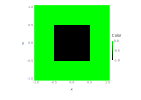

In [17]:
plot_nodes(g, p)

Finally we assemble the linear system for each method and measure the difference from the true solution.

In [22]:
# Assemble the linear system using the face based mass matrix M
W = assemble_W(g);
D = assemble_D(g);
assert(norm(D*u_sol) < 0.0001); #verify that the divergence operator is correct
G = -g.dx*g.dx*W*D';
println(full(D'));
#println(full(G));
#println(norm(u_sol - u + G*p));
#assert(norm(u_sol - u + G*p) <= 0.5*g.dx); #verify that the gradient operator is correct
A = D*G;
b = D*u;
#println(full(A));
#println(full(b));
#println(size(D));
#println(size(full(A)));
#println(b);
pnew = A\b;
unew = u - G*pnew;
#force_neumann!(g, A, b, p);
println("Result: $(norm(p-pnew, Inf))");

[-1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 1.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 1.0 -1.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 -1.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 1.0 -1.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 -1.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0
 0.0 1.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0
 0.0 0.0 1.0 0.0 0.0 -1.0 0.0 0.0 0.0
 0.0 0.0 0.0 1.0 0.0 0.0 -1.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 0.0 0.0 -1.0 0.0
 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 -1.0
 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
Result: 0.4439369549014691


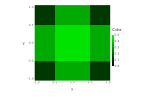

In [20]:
plot_nodes(g, abs(p-pnew))

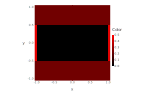

In [21]:
plot_hedges(g, abs(u_sol-unew))

In [14]:
plot_vedges(g, abs(u_sol-unew))

## Convergence
We will now look at the convergence of the projection method with respect to grid size.

In [12]:
# Define priniting routines
function printheader()
    @printf(" grid  , P inf-norm , order , v inf-norm , order , P two-norm , order , v two-norm , order , P one-norm , order , v one-norm , order \n");
end

function printdata!(g::MFDGrid, pdiff, udiff, prev)
    pmax = norm(pdiff, Inf);
    p2 = 0.5*g.dx*norm(pdiff, 2);
    p1 = 0.25*g.dx*g.dx*norm(pdiff, 1);    
    umax = norm(udiff, Inf);
    u2 = 0.5*g.dx*norm(udiff, 2);
    u1 = 0.25*g.dx*g.dx*norm(udiff, 1);
    data = [pmax, umax, p2, u2, p1, u1];

    order = zeros(6);
    if ( prev != zeros(6) )
        order = log2(prev./data);
    end
    
    @printf("%4d^2 , %8.4e , %5.2f , %8.4e , %5.2f", g.n-1, data[1], order[1], data[2], order[2]);
    @printf(" , %8.4e , %5.2f , %8.4e , %5.2f", data[3], order[3], data[4], order[4]);
    @printf(" , %8.4e , %5.2f , %8.4e , %5.2f \n", data[5], order[5], data[6], order[6]);
    prev[:] = data;
end;

In [13]:
# Convenience routine to assemble system given a pressure, input velocity and output velocity functions
function assemble(dx, pres, v_in, v_out)
    # Assemble the linear system using the edge based mass matrix M
    g = init_grid(dx);
    p, u_in, u_sol = init(g, pres, v_in, v_out);
    D = assemble_D(g);
    W = assemble_W(g);
    G = -dx*dx*W*D';
    A = D*G;
    b = D*u_in;
    A, b, G, p, u_in, u_sol, g
end
# Convenience method to solve a given system and output the error from the ground truth
function solve(A, b, G, p, u_in, u_sol)
    pnew = A\b;
    unew = u_in - G*pnew;
    pdiff = p - pnew;
    udiff = u_sol - unew;
    pdiff, udiff
end;

In [14]:
is3 = [1:10];
dxs = 2./2.^is3;
printheader();
prev = zeros(6); # a previous set of data
data3 = Array(Float64,(length(is3),6));
for i in is3
    dx = dxs[i];
    A, b, G, p, u_in, u_sol, g = assemble(dx, pressure3, input_velocity3, output_velocity3);
    #assert(norm(u_sol - u_in + G*p) <= 0.5*dx);
    #pin_pressure!(GtMG, rhs, p, [div(g.n*g.n, 2)]);
    #force_dirichlet!(GtMG, rhs, p, n);
    pdiff, udiff = solve(A, b, G, p, u_in, u_sol);
    printdata!(g, pdiff, udiff, prev);
    data3[i,1:6] = prev;
end

 grid  , P inf-norm , order , v inf-norm , order , P two-norm , order , v two-norm , order , P one-norm , order , v one-norm , order 
   2^2 , 5.5360e-02 ,  0.00 , 6.9389e-17 ,  0.00 , 5.5360e-02 ,  0.00 , 9.8131e-17 ,  0.00 , 5.5360e-02 ,  0.00 , 1.3878e-16 ,  0.00 
   4^2 , 2.2339e-02 ,  1.31 , 7.2858e-16 , -3.39 , 1.3086e-02 ,  2.08 , 3.3762e-16 , -1.78 , 1.1170e-02 ,  2.31 , 3.8424e-16 , -1.47 
   8^2 , 6.2089e-03 ,  1.85 , 1.3045e-15 , -0.84 , 3.2273e-03 ,  2.02 , 6.1403e-16 , -0.86 , 2.6498e-03 ,  2.08 , 6.9215e-16 , -0.85 
  16^2 , 1.5927e-03 ,  1.96 , 5.7176e-15 , -2.13 , 8.0409e-04 ,  2.00 , 1.5271e-15 , -1.31 , 6.5387e-04 ,  2.02 , 1.5385e-15 , -1.15 
  32^2 , 4.0074e-04 ,  1.99 , 1.0381e-14 , -0.86 , 2.0085e-04 ,  2.00 , 3.5078e-15 , -1.20 , 1.6294e-04 ,  2.00 , 3.6096e-15 , -1.23 
  64^2 , 1.0035e-04 ,  2.00 , 4.1134e-14 , -1.99 , 5.0203e-05 ,  2.00 , 1.8309e-14 , -2.38 , 4.0701e-05 ,  2.00 , 2.1101e-14 , -2.55 
CHOLMOD warning: matrix not positive definite
 128^2 , 2.5096e

In [35]:
# Define plotting routines
function plot_results(xdata,ydata,ylabel)
    logydata = log2(ydata);
    a,b = linreg(xdata, logydata);
    pl = plot(x=xdata, y=logydata, Guide.XLabel("Grid Size"), Guide.YLabel("Log( $ylabel )"), Geom.point);
    append!(pl.layers, layer(x=xdata, y=[a+b*i for i in xdata], Geom.line));
    println("slope = $b");
    println("R = $(cor(xdata,logydata))");
    pl
end;

slope = 1.2729109366284513e-8
R = 0.999999999995453


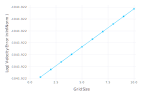

In [23]:
plot_results([1.0:size(data3, 1)], data3[:,2], "Velocity Error in Inf-Norm")

slope = NaN
R = NaN


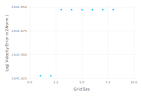

In [24]:
plot_results([1.0:size(data3, 1)], data3[:,4], "Velocity Error in 2-Norm")

slope = NaN
R = NaN


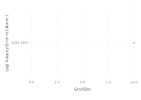

In [25]:
plot_results([1.0:size(data3, 1)], data3[:,6], "Velocity Error in 1-Norm")